# Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

# Convert Images To Numpy Arrays

In [2]:
#path to image folders
labels = ['rugby', 'soccer'] #FIXME
img_size_x = 224 #FIXME
img_size_y = 224 #FIXME

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label) 
        class_num = labels.index(label) #index of label
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format, since imread returns BGR
                resized_arr = cv2.resize(img_arr, (img_size_x, img_size_y)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Training and Validation

In [3]:
#train and validation data
train = get_data('./Images/train')
val = get_data('./Images/test')

<ipython-input-2-62ecdae941a3>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


### Display Images and Plot of Training Data

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

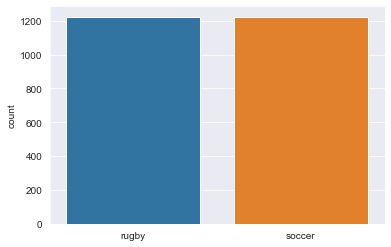

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("rugby")
    else:
        l.append("soccer")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'rugby')

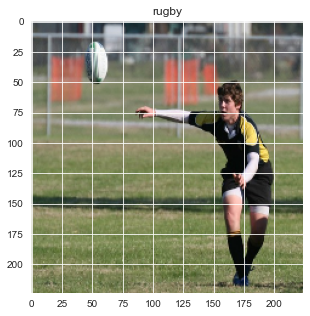

In [5]:
#display an example image for rugby
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

In [1]:
#display an example image for soccer
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

NameError: name 'plt' is not defined

# Normalize Data

In [7]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size_x, img_size_y, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size_x, img_size_y, 1)
y_val = np.array(y_val)

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Create CNN Model

In [9]:
#CNN model with 3 Convolutional layers followed by max-pooling layers, dropout layer added after 3rd maxpool operation to avoid overfitting
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3))) #CHANGE LATER
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

# Compile and Train Model

In [10]:
#compile model using Adam as optimizer and SparseCategoricalCrossentropy as the loss function
opt = Adam(lr=0.000001) #CHANGE LATER
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
#train for 500 epochs
history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val)) #CHANGE LATER

Epoch 1/500


C:\Users\joeal\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


77/77 [==============================] - 57s 735ms/step - loss: 0.6949 - accuracy: 0.5110 - val_loss: 0.6937 - val_accuracy: 0.4869
Epoch 2/500
77/77 [==============================] - 61s 796ms/step - loss: 0.6927 - accuracy: 0.5139 - val_loss: 0.6900 - val_accuracy: 0.5197
Epoch 3/500
77/77 [==============================] - 61s 788ms/step - loss: 0.6895 - accuracy: 0.5380 - val_loss: 0.6862 - val_accuracy: 0.5410
Epoch 4/500
77/77 [==============================] - 61s 792ms/step - loss: 0.6867 - accuracy: 0.5523 - val_loss: 0.6794 - val_accuracy: 0.6590
Epoch 5/500
77/77 [==============================] - 62s 799ms/step - loss: 0.6853 - accuracy: 0.5523 - val_loss: 0.6766 - val_accuracy: 0.6230
Epoch 6/500
77/77 [==============================] - 64s 828ms/step - loss: 0.6817 - accuracy: 0.5719 - val_loss: 0.6720 - val_accuracy: 0.6672
Epoch 7/500
77/77 [==============================] - 58s 747ms/step - loss: 0.6796 - accuracy: 0.5768 - val_loss: 0.6668 - val_accuracy: 0.6869
Epoc

# Plot Training and Validation Accuracy/Loss

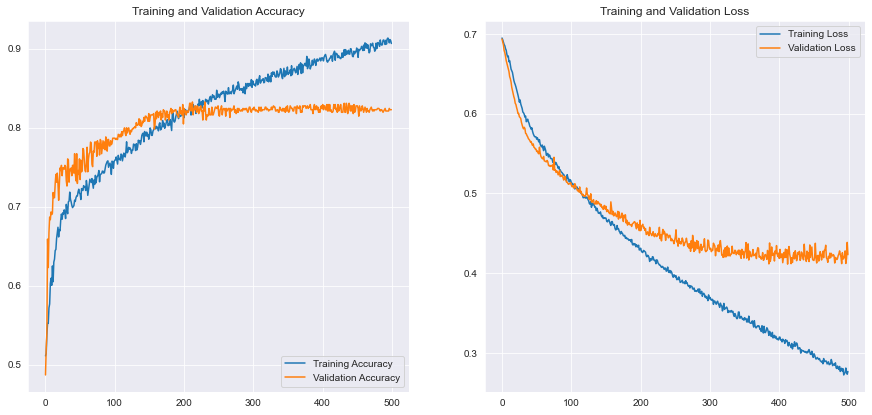

In [12]:
#plot training and validation accuracy along with training and validation loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500) #change according to # of epochs

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Results

In [13]:
#print classification report
#predictions = model.predict_classes(x_val)
#predictions = predictions.reshape(1,-1)[0]
#print(classification_report(y_val, predictions, target_names = ['Rugby (Class 0)','Soccer (Class 1)']))

predict_x=model.predict(x_val) 
classes_x=np.argmax(predict_x,axis=1)
predictions = classes_x
predictions = predictions.reshape(1,-1)[0]
print(predictions)
print(y_val)
print(classification_report(y_val, predictions, target_names = ['Rugby (Class 0)','Soccer (Class 1)']))


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1
 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1
 0 1 0 1 1 1 1 0 1 0 1 1 

# Testing Field Data

In [33]:
#testing on unseen data
field = get_data('./Images/field')
x_field = []
y_field = []
for feature, label in field:
    x_field.append(feature)
    y_field.append(label)
x_field = np.array(x_field) / 255
x_field.reshape(-1, img_size_x, img_size_y, 1)
y_field = np.array(y_field)
y_field

<ipython-input-2-62ecdae941a3>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

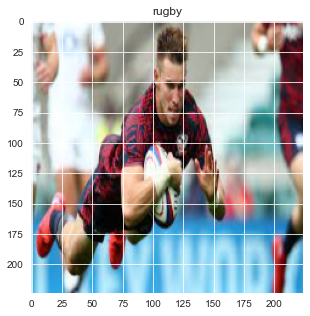

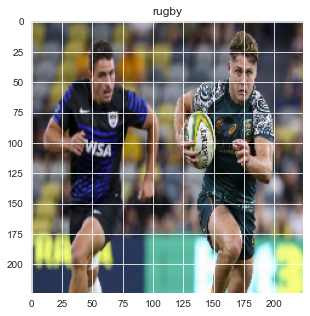

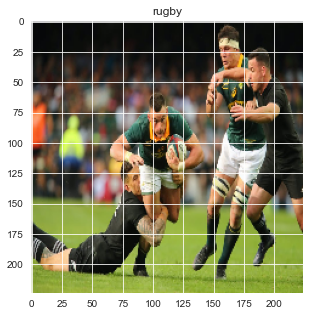

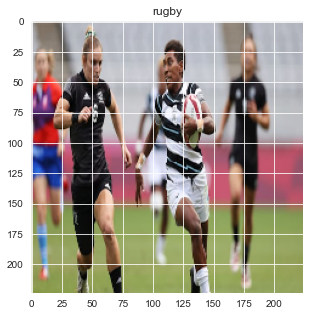

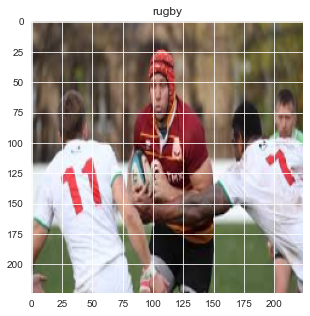

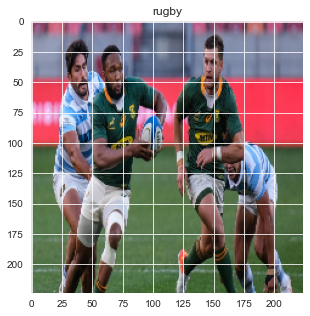

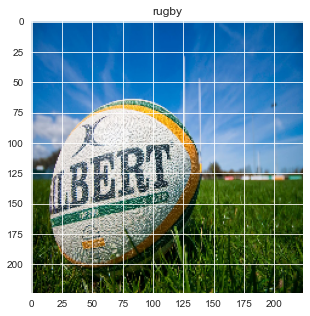

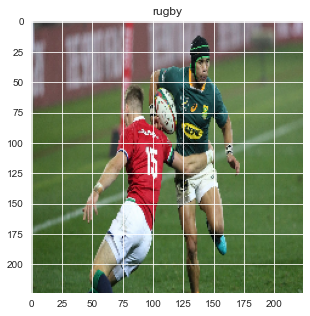

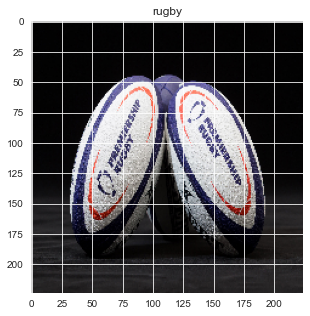

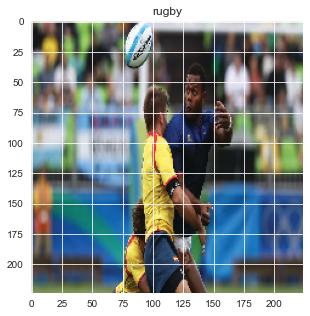

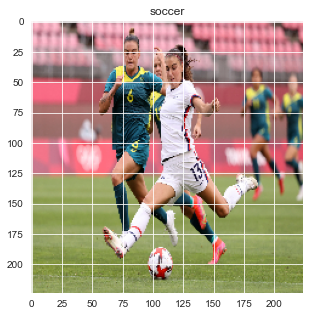

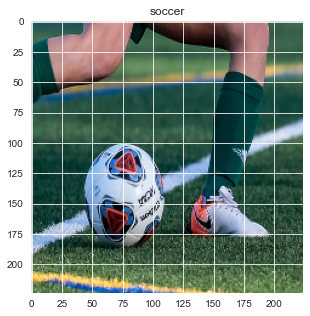

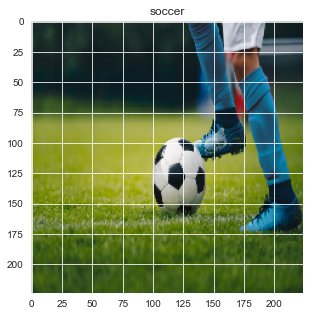

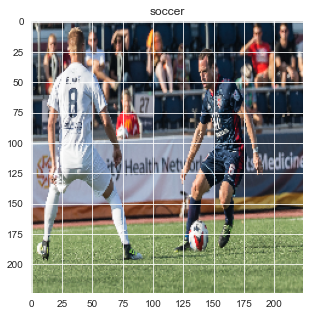

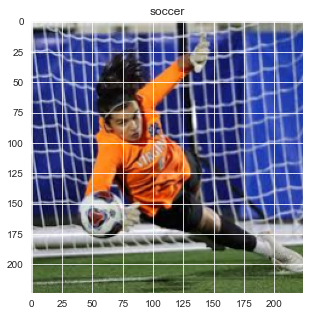

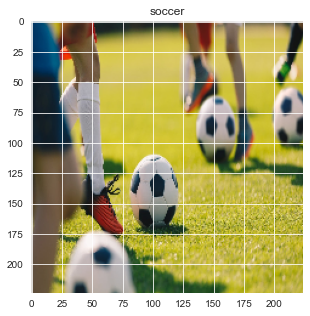

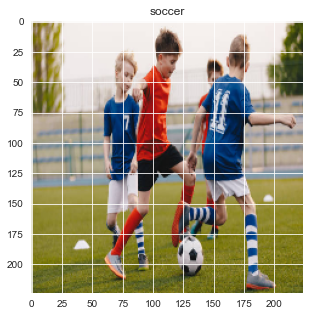

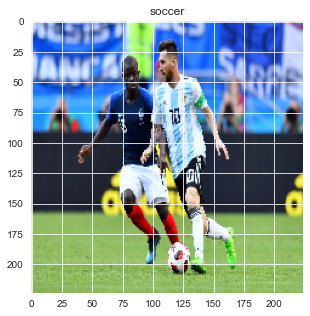

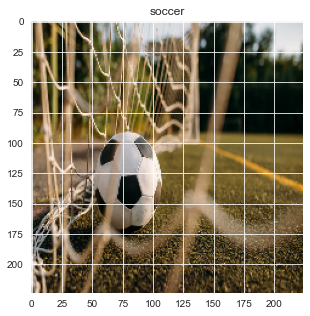

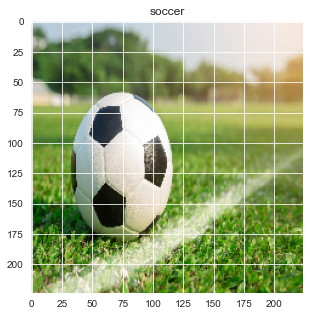

In [34]:
for i in range(y_field.size):
    plt.figure(figsize = (5,5))
    plt.imshow(field[i][0]) #data[X][Y] X is pic number, Y is 0 for values, Y is 1 for category
    plt.title(labels[field[i][1]])

In [35]:
predict_x_field = model.predict(x_field)
classes_x_field = np.argmax(predict_x_field, axis=1)
predictions_field = classes_x_field
predictions_field = predictions_field.reshape(1,-1)[0]
print(predict_x_field) #predicted with % confidence
print(predictions_field) #predicted labels
print(y_field) #actual labels
print(classification_report(y_field, predictions_field, target_names = ['Rugby (Class 0)','Soccer (Class 1)']))

[[0.36051694 0.63948303]
 [0.61412555 0.38587445]
 [0.8365132  0.16348678]
 [0.23492739 0.7650726 ]
 [0.74040514 0.25959483]
 [0.96224725 0.03775268]
 [0.7209359  0.2790641 ]
 [0.12577434 0.8742257 ]
 [0.53992957 0.4600704 ]
 [0.25786483 0.7421351 ]
 [0.00970374 0.9902963 ]
 [0.66991407 0.3300859 ]
 [0.15590304 0.84409696]
 [0.29922137 0.7007786 ]
 [0.6803482  0.31965172]
 [0.13041012 0.86958987]
 [0.10170038 0.8982996 ]
 [0.13526462 0.8647354 ]
 [0.9303651  0.06963495]
 [0.34836155 0.65163845]]
[1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
                  precision    recall  f1-score   support

 Rugby (Class 0)       0.67      0.60      0.63        10
Soccer (Class 1)       0.64      0.70      0.67        10

        accuracy                           0.65        20
       macro avg       0.65      0.65      0.65        20
    weighted avg       0.65      0.65      0.65        20



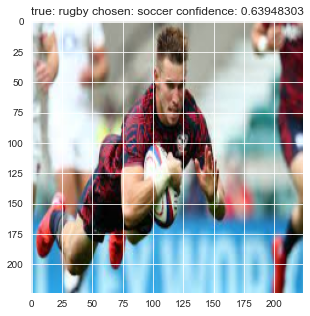

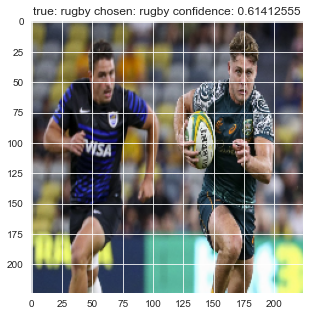

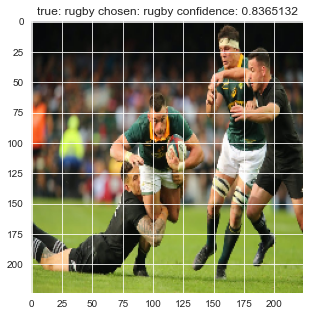

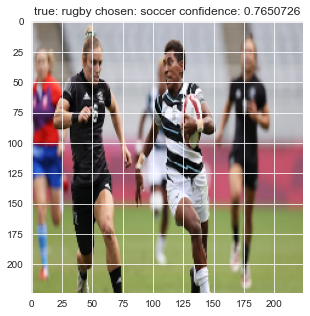

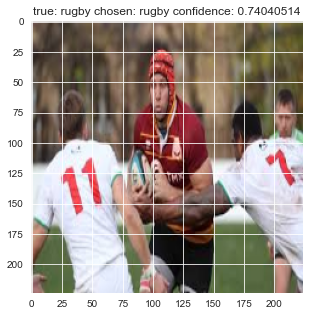

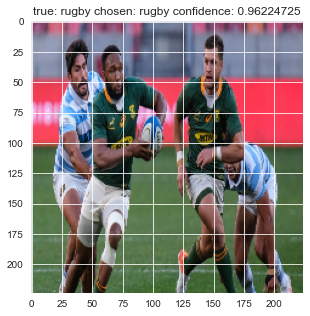

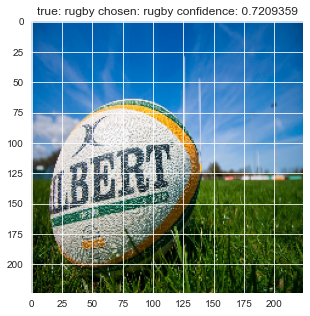

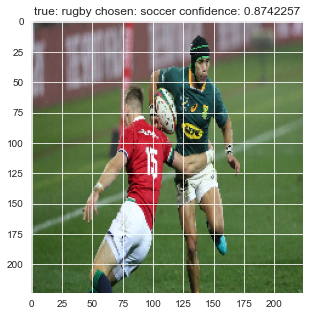

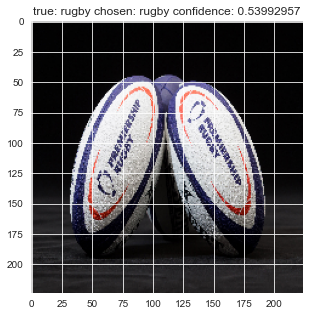

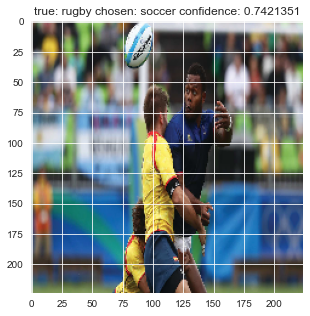

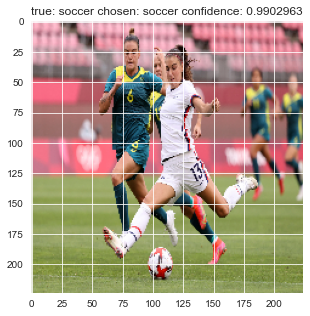

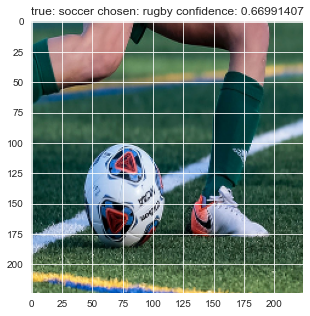

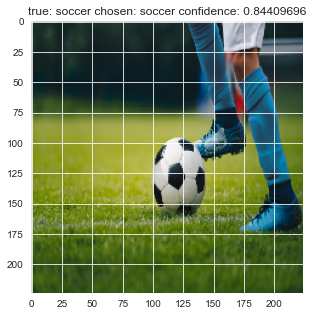

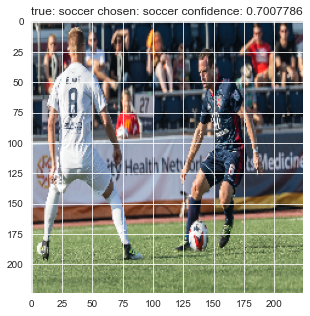

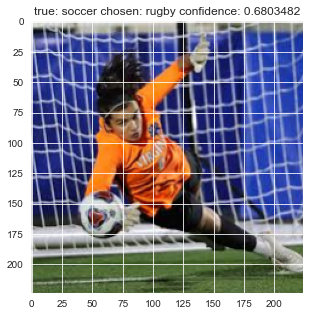

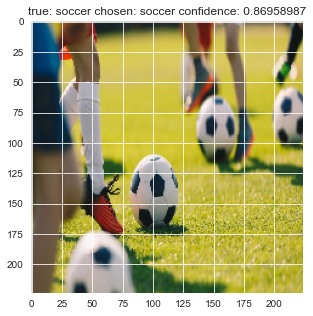

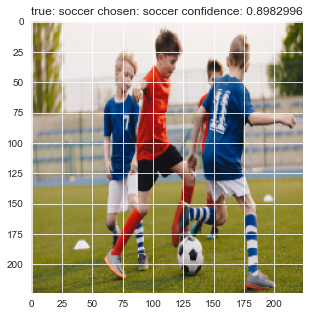

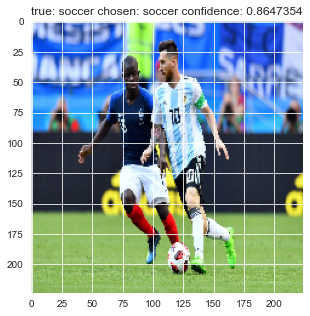

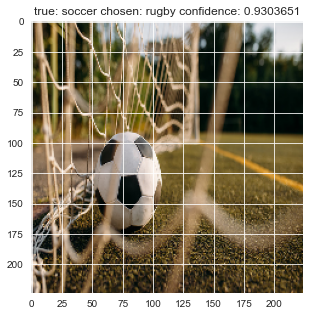

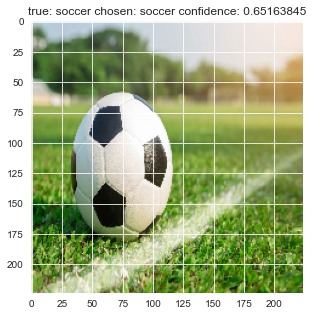

In [36]:
for i in range(y_field.size):
    #if y_field[i] != predictions_field[i]: #uncomment this line just to see wrong predictions only
    plt.figure(figsize = (5,5))
    plt.imshow(field[i][0]) #data[X][Y] X is pic number, Y is 0 for values, Y is 1 for category
    plt.title("true: "+labels[y_field[i]]+" chosen: "+labels[predictions_field[i]]+" confidence: "+str(max(predict_x_field[i][0], predict_x_field[i][1])))
#one notable problem is if the image is resized/stretched, the shape and hence the result between rugby and soccer shanges
#this should not be a problem for our project, since we always capture the same images

# Save the Model Into a file

In [37]:
keras_model_path = 'tmp'
model.save(keras_model_path)

INFO:tensorflow:Assets written to: tmp\assets


# Load Model from File

In [38]:
restored_keras_model = tf.keras.models.load_model(keras_model_path)

In [39]:
#testing restored model from contents
predict_x_field = restored_keras_model.predict(x_field)
classes_x_field = np.argmax(predict_x_field, axis=1)
predictions_field = classes_x_field
predictions_field = predictions_field.reshape(1,-1)[0]
print(predict_x_field) #predicted with % confidence
print(predictions_field) #predicted labels
print(y_field) #actual labels
print(classification_report(y_field, predictions_field, target_names = ['Rugby (Class 0)','Soccer (Class 1)']))

[[0.36051694 0.63948303]
 [0.61412555 0.38587445]
 [0.8365132  0.16348678]
 [0.23492739 0.7650726 ]
 [0.74040514 0.25959483]
 [0.96224725 0.03775268]
 [0.7209359  0.2790641 ]
 [0.12577434 0.8742257 ]
 [0.53992957 0.4600704 ]
 [0.25786483 0.7421351 ]
 [0.00970374 0.9902963 ]
 [0.66991407 0.3300859 ]
 [0.15590304 0.84409696]
 [0.29922137 0.7007786 ]
 [0.6803482  0.31965172]
 [0.13041012 0.86958987]
 [0.10170038 0.8982996 ]
 [0.13526462 0.8647354 ]
 [0.9303651  0.06963495]
 [0.34836155 0.65163845]]
[1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
                  precision    recall  f1-score   support

 Rugby (Class 0)       0.67      0.60      0.63        10
Soccer (Class 1)       0.64      0.70      0.67        10

        accuracy                           0.65        20
       macro avg       0.65      0.65      0.65        20
    weighted avg       0.65      0.65      0.65        20

